# Training Models to Classify Driver Behaviors

In [2]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import umap
from sklearn.preprocessing import LabelEncoder
from tsfresh.feature_extraction import extract_features
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA


In [68]:
FOLDER_NAME = 'ufscar'
labels = pd.read_csv(f'{FOLDER_NAME}/data/labels.csv')
y = labels['Type'].values

label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(y)

ids = labels['ID'].values
df_list = []
id_count = 0
for filename in ids:

    filename = str(filename)
    if filename.startswith('v'):
        continue

    path = filename + '.csv'
    df = pd.read_csv(os.path.join(f'{FOLDER_NAME}/data', path))
    df['id'] = id_count
    df_list.append(df)
    id_count += 1

## Sliding Windows

In [4]:
def create_sliding_windows(data, labels, window_size=15, step_size=5, drop_columns=['time', 'id']):
    # This function returns the sliding windows and the labels for each window
    # If output_3d is True, the output will be a 3D array, otherwise it will be a 2D array
    # The 2D array is (num_samples, num_features), useful for ML and the 3D array is (num_samples, window_size/time_steps, num_features), useful for RNNs
    # The difference is that the window is not flattened in the 3D array
    X = []
    y = []
    for k in range(len(data)):
        for i in range(0, len(data[k]) - window_size + 1, step_size):
            end = i + window_size

            if end > len(data[k]):
                end = len(data[k])
            
            window_label = labels[k]
            window = data[k][i:end].drop(drop_columns, axis=1) # Dropping 'evento' and 'seconds_passed' columns

            if len(window) < window_size:
                padding = np.zeros((window_size - len(window), len(window.columns))) # Padding the window with zeros and the same amount of columns
                window = np.vstack([window, padding]) # Stacking the window and padding keeping the same order
            
            X.append(np.array(window).flatten())
            y.append(window_label)

    return np.array(X), np.array(y)

In [5]:
def visualize_tsne_2d(data, y_numeric, perplexity=30, learning_rate=200):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, learning_rate=learning_rate)
    X_tsne = tsne.fit_transform(data)

    plt.figure(figsize=(10, 8))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_numeric, cmap='viridis', s=5)
    plt.colorbar(boundaries=np.arange(len(np.unique(y_numeric))+1)-0.5).set_ticks(np.arange(len(np.unique(y_numeric))))
    plt.title('t-SNE 2D Projection')
    plt.show()

In [6]:
def visualize_umap_2d(data, y_numeric, n_neighbors=5, min_dist=0.1, metric='euclidean'):
    X_umap = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, metric=metric).fit_transform(data)
    plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_numeric, cmap='Spectral', s=5)
    plt.colorbar(boundaries=np.arange(len(np.unique(y_numeric))+1)-0.5).set_ticks(np.arange(len(np.unique(y_numeric))))
    plt.title("UMAP 2D")
    plt.show()

In [7]:
def visualize_umap_3d(data, labels=None, n_neighbors=15, min_dist=0.1, metric='euclidean', spread=0.2, title="UMAP 3D Projection"):
    """
    Visualize UMAP embeddings in 3D.

    Parameters:
        data (np.array or pd.DataFrame): High-dimensional data to reduce.
        labels (np.array or pd.Series): Labels for coloring the points (optional).
        n_neighbors (int): Number of neighbors for UMAP.
        min_dist (float): Minimum distance between points in the UMAP embedding.
        metric (str): Distance metric for UMAP.
        title (str): Title of the plot.
    """
    # Perform UMAP dimensionality reduction to 3D
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=3,  # Reduce to 3 dimensions
        metric=metric,
        spread=spread,
        random_state=42
    )
    embedding = reducer.fit_transform(data)

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the points
    if labels is not None:
        scatter = ax.scatter(
            embedding[:, 0],  # X-axis
            embedding[:, 1],  # Y-axis
            embedding[:, 2],  # Z-axis
            c=labels,         # Color by labels
            cmap='Spectral',  # Colormap
            s=50,             # Point size
            alpha=0.8         # Transparency
        )
        # Add a colorbar
        cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
        cbar.set_label('Labels')
    else:
        ax.scatter(
            embedding[:, 0],
            embedding[:, 1],
            embedding[:, 2],
            s=50,
            alpha=0.8
        )

    # Set labels and title
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_zlabel('UMAP 3')
    ax.set_title(title)

    # Show the plot
    plt.show()

In [8]:
def fit_kNN(X, y):

    X = StandardScaler().fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    best_params = GridSearchCV(KNeighborsClassifier(), param_grid={'n_neighbors': [1, 3, 5, 7, 9, 10, 11, 15, 20]}, cv=5).fit(X_train, y_train).best_params_
    print(best_params)

    knn = KNeighborsClassifier(**best_params)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    return classification_report(y_test, y_pred)

In [42]:
window_size = 20
step_size = 10

In [43]:
X_sliding, y_sliding = create_sliding_windows(df_list, y_numeric, window_size=window_size, step_size=step_size)
X_sliding.shape, y_sliding.shape

((9025, 100), (9025,))

## Using FFT as features

In [44]:
def get_fft(data, window_size):
    X_fft = np.fft.fft(data.reshape(data.shape[0], window_size, data.shape[1]//window_size), axis=1)
    X_fft = X_fft[:, :window_size//2 + 1, :] # Get first half to avoid redundancy
    X_fft = np.concatenate([np.abs(X_fft), np.angle(X_fft)], axis=1)
    X_fft = X_fft.reshape(X_fft.shape[0], X_fft.shape[1]*X_fft.shape[2])
    return X_fft

In [45]:
X_fft = get_fft(X_sliding, window_size)

/home/renan/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


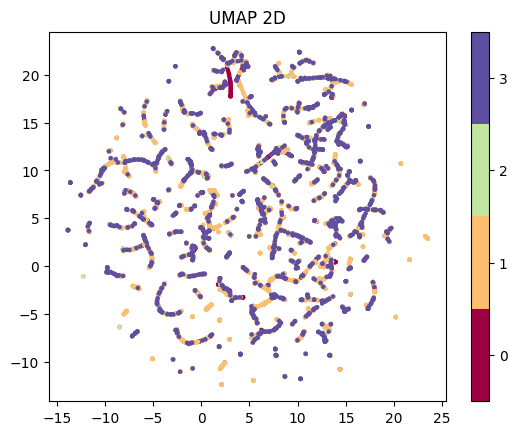

In [46]:
visualize_umap_2d(X_fft, y_sliding)

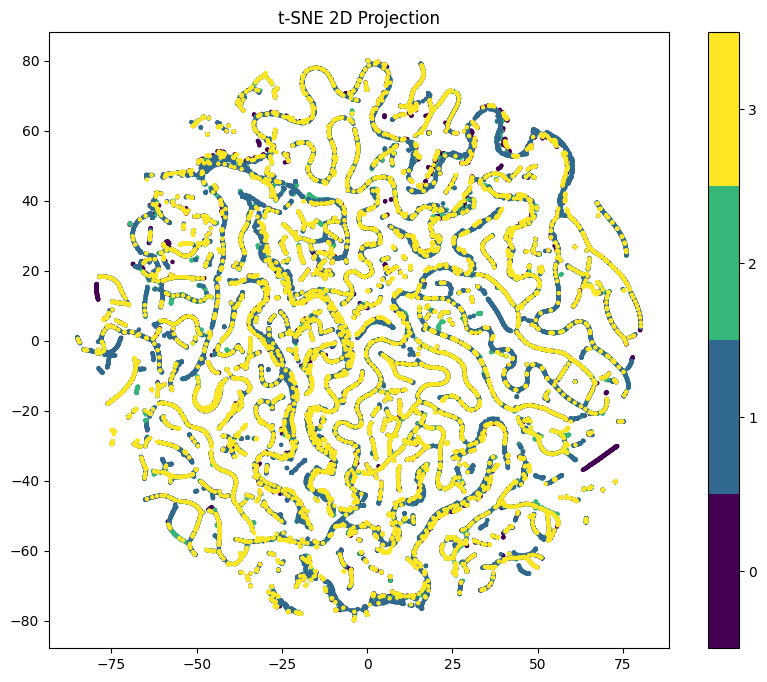

In [20]:
visualize_tsne_2d(X_fft, y_sliding)

In [21]:
print(fit_kNN(X_fft, y_sliding))

{'n_neighbors': 15}
              precision    recall  f1-score   support

           0       0.54      0.43      0.48      1935
           1       0.62      0.81      0.70      3264
           2       0.50      0.49      0.49      2653
           3       0.76      0.55      0.64      1744

    accuracy                           0.60      9596
   macro avg       0.61      0.57      0.58      9596
weighted avg       0.60      0.60      0.59      9596



## Using DTW as a distance metric

In [ ]:
from dtaidistance.dtw import distance_matrix_fast
distance_matrix = distance_matrix_fast(X_sliding)

In [10]:
# Convert the distance matrix to a DataFrame
distance_matrix_df = pd.DataFrame(distance_matrix)

# Define the output path
output_path = os.path.join(FOLDER_NAME, 'distance_matrix', 'distance_matrix.csv')

# Ensure the directory exists
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Write the DataFrame to a CSV file
distance_matrix_df.to_csv(output_path, index=False)

/home/renan/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/.local/lib/python3.10/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/renan/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


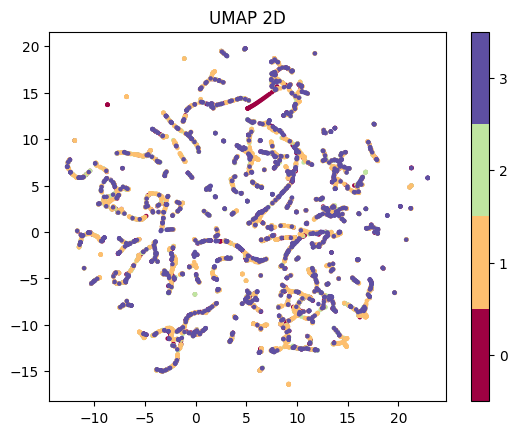

In [12]:
visualize_umap_2d(distance_matrix, y_sliding, n_neighbors=5, min_dist=0.1, metric='precomputed')

/home/renan/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/.local/lib/python3.10/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/renan/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


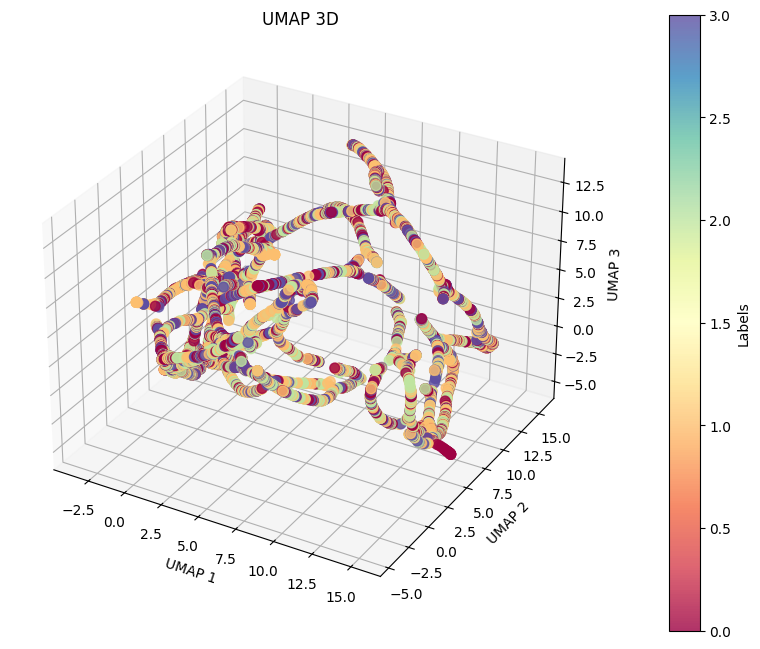

In [13]:
visualize_umap_3d(distance_matrix, y_sliding, n_neighbors=15, min_dist=0.1, metric='precomputed', title='UMAP 3D')

## Removing x_pos and y_pos

In [23]:
X_sliding, y_sliding = create_sliding_windows(df_list, y_numeric, window_size=7, step_size=2, drop_columns=['time', 'id', 'x_pos', 'y_pos'])
X_sliding.shape, y_sliding.shape

((47976, 21), (47976,))

/home/renan/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


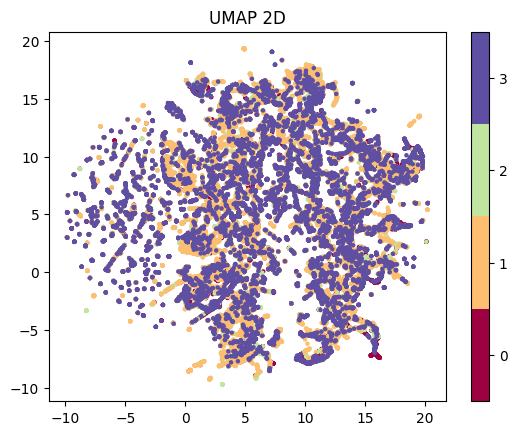

In [24]:
visualize_umap_2d(X_sliding, y_sliding, n_neighbors=5, min_dist=0.1, metric='euclidean')

/home/renan/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/.local/lib/python3.10/site-packages/umap/umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/renan/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/renan/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


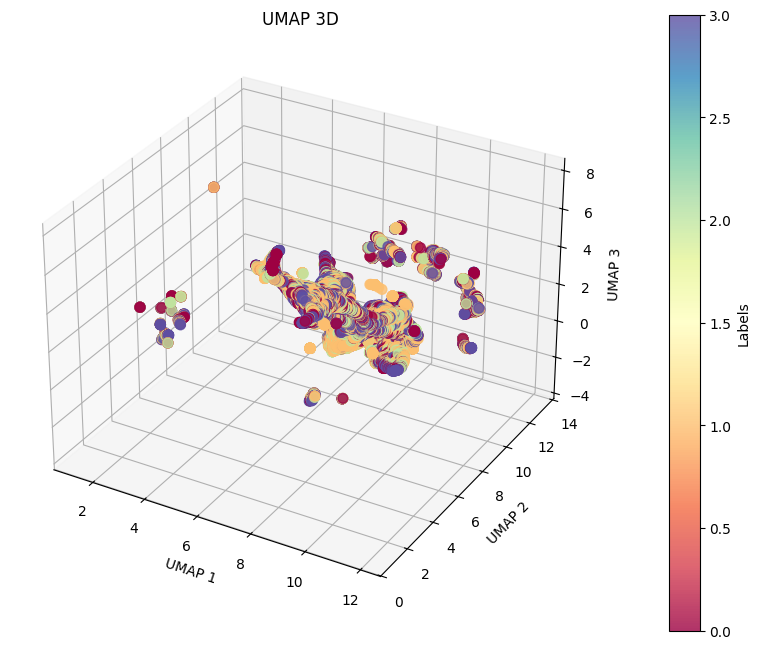

In [25]:
visualize_umap_3d(X_sliding, y_sliding, n_neighbors=15, min_dist=0.1, metric='euclidean', title='UMAP 3D')

## Removing X, Y and scaling the data

In [78]:
X_sliding, y_sliding = create_sliding_windows(df_list, y, window_size=20, step_size=20, drop_columns=['time', 'id', 'x_pos', 'y_pos'])
y_sliding = label_encoder.transform(y_sliding)
X_sliding = StandardScaler().fit_transform(X_sliding)
X_sliding.shape, y_sliding.shape

((4673, 60), (4673,))

In [ ]:
def plot_umaps_2d(X, y, window_sizes, step_sizes, n_neighbors, min_dists, metrics):

    total_plots = len(window_sizes) * len(step_sizes) * len(n_neighbors) * len(min_dists) * len(metrics)
    fig, axs = plt.subplots(np.ceil(total_plots/3), n_columns=3, figsize=(20, 20))
    axs = axs.flatten()

    count = 0
    for w_size in window_sizes:
        for s_size in step_sizes:
            if s_size > window_size:
                continue
            for n_nei in n_neighbors:
                for min_dist in min_dists:
                    for metric in metrics:
                        X_sliding, y_sliding = create_sliding_windows(X, y, window_size=w_size, step_size=s_size, drop_columns=['time', 'id', 'x_pos', 'y_pos'])
                        y_sliding = label_encoder.transform(y_sliding)
                        X_sliding = StandardScaler().fit_transform(X_sliding)

                        X_umap = umap.UMAP(n_neighbors=n_nei, min_dist=min_dist, n_components=2, metric=metric).fit_transform(X_sliding)

                        axs[count].scatter(X_umap[:, 0], X_umap[:, 1], c=y_sliding, cmap='Spectral', s=5)
                        axs[count].colorbar(boundaries=np.arange(len(np.unique(y_sliding))+1)-0.5).set_ticks(np.arange(len(np.unique(y_sliding))))
                        axs[count].title(f"w_size: {w_size}, s_size: {s_size}, neigh: {n_nei}, min_dist: {min_dist}, metric: {metric}")
                        plt.title("UMAP 2D")
                        count += 1                         
    plt.show()        

In [ ]:
window_sizes = [5, 10, 15, 20]
step_sizes = [5, 10, 15, 20]
n_neighbors = [5, 10, 15, 20]
min_dists = [0.1, 0.2, 0.3]
metrics = ['euclidean', 'manhattan', 'cosine']

plot_umaps_2d

/home/renan/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


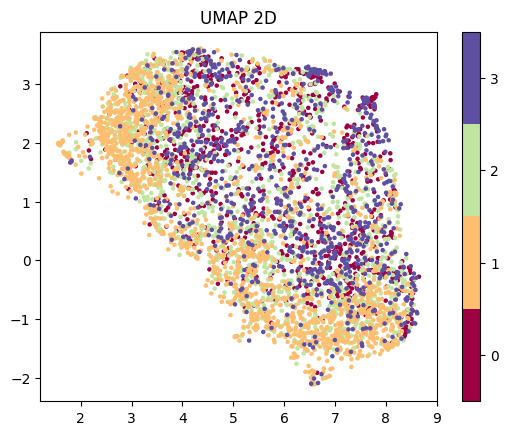

In [84]:
visualize_umap_2d(X_sliding, y_sliding, n_neighbors=500, min_dist=0.05, metric='euclidean')

/home/renan/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/.local/lib/python3.10/site-packages/umap/umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/renan/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


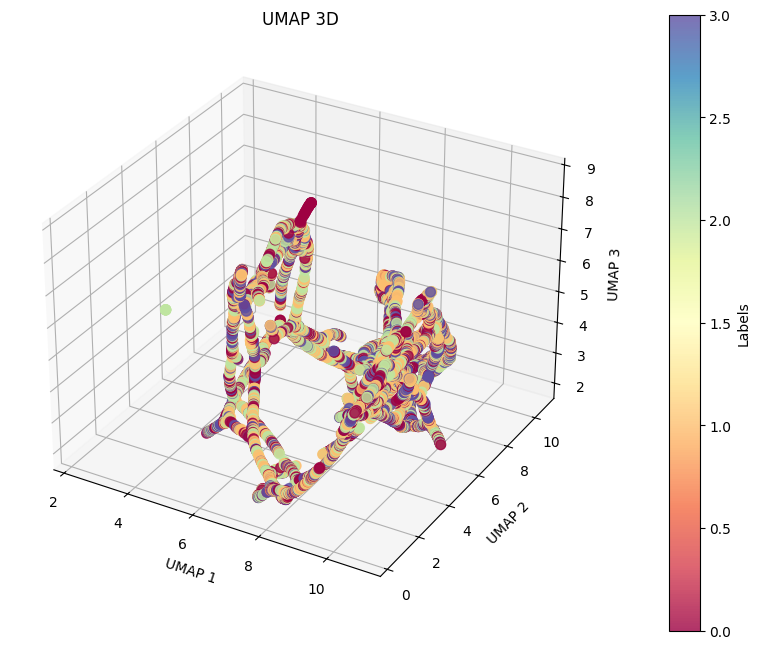

In [48]:
visualize_umap_3d(X_sliding, y_sliding, n_neighbors=np.sqrt(len(X_sliding[0])), min_dist=0.1, metric='euclidean', title='UMAP 3D')

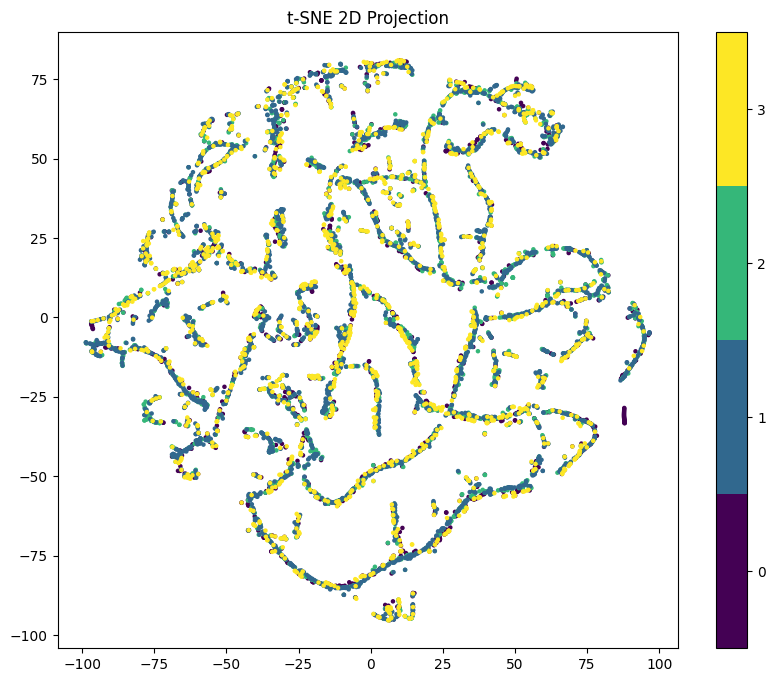

In [ ]:
visualize_tsne_2d(X_sliding, y_sliding, perplexity=30, learning_rate=500)

## Let's try kNN to see if it is possible to cluster the data

In [65]:
print(fit_kNN(X_sliding, y_sliding)) # Terrible results

{'n_neighbors': 1}
              precision    recall  f1-score   support

           0       0.51      0.40      0.45       371
           1       0.64      0.76      0.69       651
           2       0.42      0.54      0.47       470
           3       0.69      0.30      0.42       313

    accuracy                           0.55      1805
   macro avg       0.56      0.50      0.51      1805
weighted avg       0.56      0.55      0.54      1805



Seems like kNN is also not able to separate the data properly

Random Forest, on the other hand, has pretty good results

In [60]:
def fit_RF(X_train, X_test, y_train, y_test, n_estimators=100, random_state=42):
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return clf, classification_report(y_test, y_pred, target_names=list(label_encoder.classes_)), y_pred

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_sliding, y_sliding, test_size=0.2, random_state=42)

In [61]:
clf, report, y_pred = fit_RF(X_train, X_test, y_train, y_test)
print("Classification Report:\n", report)

Classification Report:
                   precision    recall  f1-score   support

      aggressive       0.87      0.81      0.84       371
        cautious       0.92      0.96      0.94       651
          normal       0.91      0.88      0.90       470
super_aggressive       0.81      0.84      0.83       313

        accuracy                           0.89      1805
       macro avg       0.88      0.87      0.87      1805
    weighted avg       0.89      0.89      0.89      1805



## DriverBehaviorDataset

### To be able to compare results, let's see what UMAP looks like for the DriverBehaviorDataset

In [146]:
def get_event(seconds_passed, groundTruth):
    for _, row in groundTruth.iterrows():
        if row[' inicio'] <= seconds_passed <= row[' fim']:
            return row['evento']
    return None

In [124]:
def getGroundTruth(df, groundTruth_orig):
    df['seconds_passed'] = (df['uptimeNanos'] - df['uptimeNanos'].iloc[0]) / 1e9 # Converting timestamp to seconds passed
    df['evento'] = df['seconds_passed'].apply(lambda x: get_event(x, groundTruth_orig)) # Getting the event for each row based on seconds passed
    return df

In [127]:
def getData(driver):
    accLinear_orig = pd.read_csv(f'dbdataset/{driver}/aceleracaoLinear_terra.csv')
    acelerometro_orig = pd.read_csv(f'dbdataset/{driver}/acelerometro_terra.csv')
    giroscopio_orig = pd.read_csv(f'dbdataset/{driver}/giroscopio_terra.csv')
    groundTruth_orig = pd.read_csv(f'dbdataset/{driver}/groundTruth.csv')

    # Renaming columns to avoid conflicts
    accLinear = accLinear_orig.rename(columns={'x': 'x_accLinear', 'y': 'y_accLinear', 'z': 'z_accLinear'}, inplace=False) 
    acelerometro = acelerometro_orig.rename(columns={'x': 'x_acelerometro', 'y': 'y_acelerometro', 'z': 'z_acelerometro'}, inplace=False) 
    giroscopio = giroscopio_orig.rename(columns={'x': 'x_giroscopio', 'y': 'y_giroscopio', 'z': 'z_giroscopio'}, inplace=False)

    # Merging all dataframes
    df = pd.concat([accLinear, acelerometro, giroscopio], axis=1)
    df = df.loc[:, ~df.columns.duplicated()]

    # Converting timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%Y %H:%M:%S')
    # Getting the event for each row based on seconds passed
    df = getGroundTruth(df, groundTruth_orig)

    # Changing Nones to 'sem_evento'
    df['evento'] = df['evento'].fillna('sem_evento')

    return df

In [133]:
def create_sliding_windows_dbdataset(data, window_size=7, step_size=1, output_3d=False):
    # This function returns the sliding windows and the labels for each window
    # If output_3d is True, the output will be a 3D array, otherwise it will be a 2D array
    # The 2D array is (num_samples, num_features), useful for ML and the 3D array is (num_samples, window_size/time_steps, num_features), useful for RNNs
    # The difference is that the window is not flattened in the 3D array

    X = []
    y = []
    # splits = np.zeros(len(data))
    cont = 0
    for k in range(len(data)):
        for i in range(0, len(data[k]) - window_size + 1, step_size):
            end = i + window_size

            if end > len(data[k]):
                end = len(data[k])

            if data[k]['evento'][i] == 'sem_evento':
                continue
            if data[k]['evento'][end - 1] == 'sem_evento':
                continue
            
            window_label = data[k]['evento'][i] # Getting the most frequent event in the window
            window = data[k][i:end].drop(['evento', 'seconds_passed'], axis=1, inplace=False) # Dropping 'evento' and 'seconds_passed' columns

            if len(window) < window_size:
                padding = np.zeros((window_size - len(window), len(window.columns))) # Padding the window with zeros and the same amount of columns
                window = np.vstack([window, padding]) # Stacking the window and padding keeping the same order


            if not output_3d:
                window = np.append(window, window.to_numpy().flatten())
            else:
                window = np.array(window)
            
            X.append(window)
            y.append(window_label)

        # splits[k] = cont

    return np.array(X), np.array(y)

In [129]:
df_16 = getData(16)
df_17 = getData(17)
df_20 = getData(20)
df_21 = getData(21)
dbdataset = [df_16, df_17, df_20, df_21]
cols = ['timestamp', 'uptimeNanos']
for i in range(len(dbdataset)):
    dbdataset[i] = dbdataset[i].drop(cols, axis=1, inplace=False)

In [143]:
X_dbdataset, y_dbdataset = create_sliding_windows_dbdataset(dbdataset, window_size=7, step_size=1)
label_encoder = LabelEncoder()
y_dbdataset_encoded = label_encoder.fit_transform(y_dbdataset)
X_dbdataset = StandardScaler().fit_transform(X_dbdataset)
X_dbdataset.shape, y_dbdataset.shape

((10663, 126), (10663,))

/home/renan/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


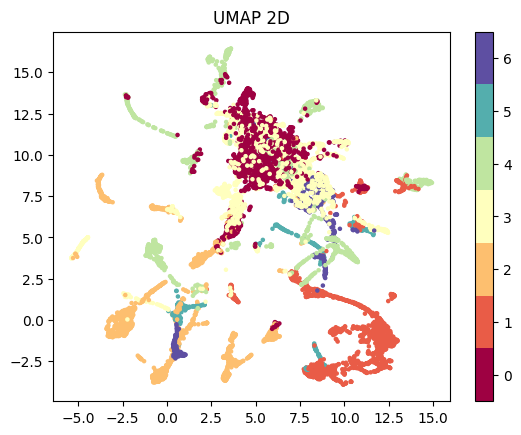

In [140]:
visualize_umap_2d(X_dbdataset, y_dbdataset_encoded, n_neighbors=5, min_dist=0.1, metric='euclidean')

/home/renan/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


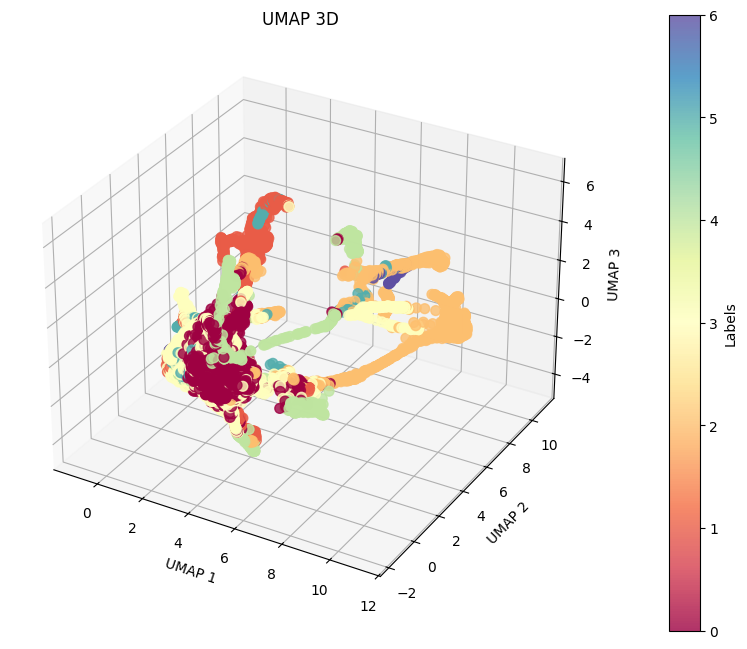

In [142]:
visualize_umap_3d(X_dbdataset, y_dbdataset, n_neighbors=15, min_dist=0.1, metric='euclidean', title='UMAP 3D')

Trying to classify this looks a lot easier

In [206]:
print(fit_kNN(X_dbdataset, y_dbdataset_encoded))

{'n_neighbors': 1}
              precision    recall  f1-score   support

           0       0.93      0.74      0.83       414
           1       0.99      0.96      0.97       387
           2       0.95      0.96      0.96       365
           3       0.77      0.94      0.85       480
           4       0.95      0.96      0.96       309
           5       0.81      0.78      0.79        94
           6       0.94      0.74      0.83        84

    accuracy                           0.90      2133
   macro avg       0.91      0.87      0.88      2133
weighted avg       0.91      0.90      0.90      2133



## Trying classification with fewer classes

In [67]:
FOLDER_NAME = 'unicamp'
labels_simple = pd.read_csv(f'{FOLDER_NAME}/data_simple/labels.csv')
y_simple = labels_simple['Type'].values

label_encoder_simple = LabelEncoder()
y_simple_numeric = label_encoder_simple.fit_transform(y_simple)

ids = labels_simple['ID'].values
df_list_simple = []
id_count = 0
for filename in ids:
    filename = str(filename)
    if filename.startswith('v'):
        continue

    path = filename + '.csv'
    df = pd.read_csv(os.path.join(f'{FOLDER_NAME}/data_simple', path))
    df['id'] = id_count
    df_list_simple.append(df)
    id_count += 1

In [63]:
window_size = 20
X_simple, y_simple = create_sliding_windows(df_list_simple, y_simple_numeric, window_size=window_size, step_size=10, drop_columns=['time', 'id'])
X_simple = StandardScaler().fit_transform(X_simple)

/home/renan/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


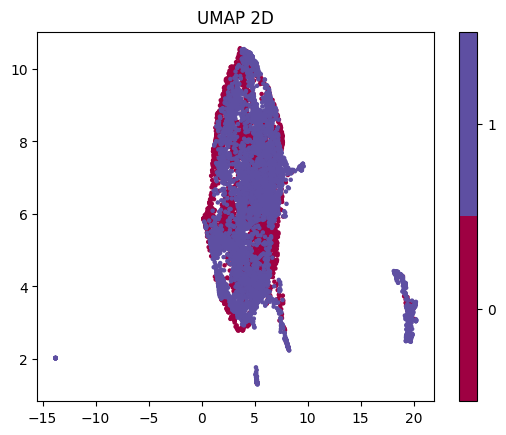

In [12]:
visualize_umap_2d(X_simple, y_simple, n_neighbors=np.sqrt(X_simple.shape[0]), min_dist=0.1, metric='euclidean')

/home/renan/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


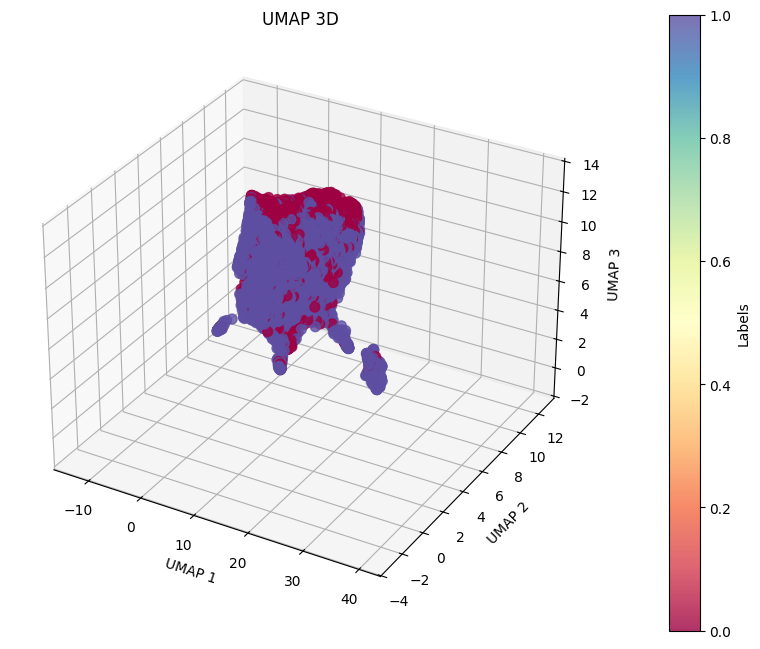

In [13]:
visualize_umap_3d(X_simple, y_simple, n_neighbors=100, min_dist=0.1, metric='euclidean', spread=2, title='UMAP 3D')

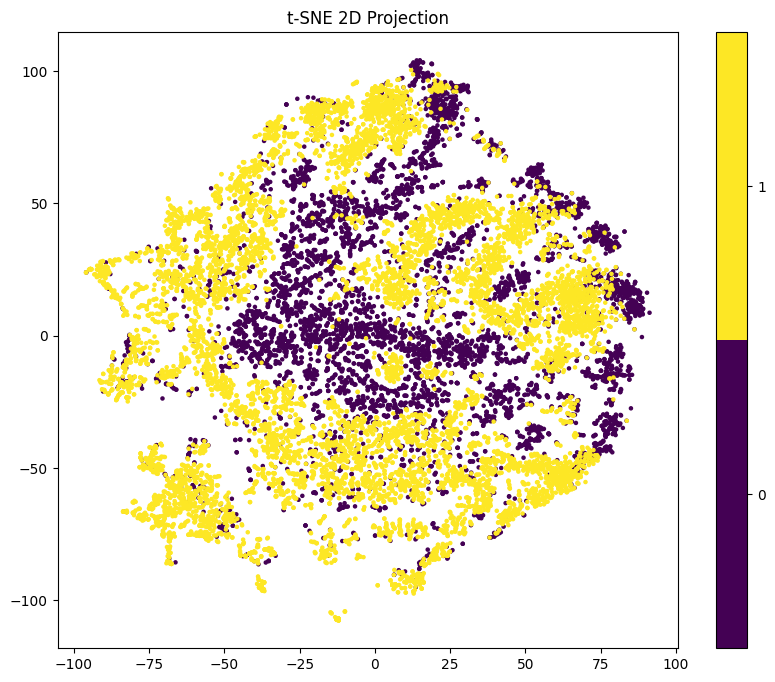

In [64]:
visualize_tsne_2d(X_simple, y_simple, perplexity=30, learning_rate=500)

/home/renan/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


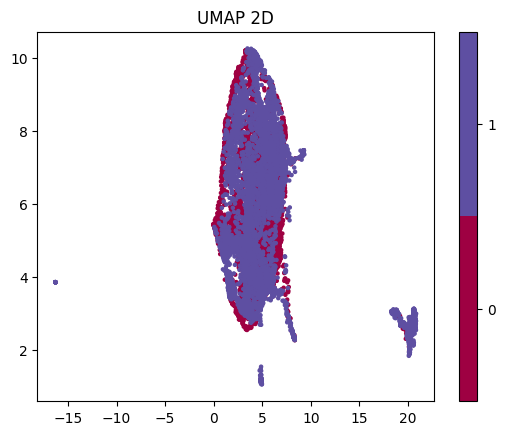

In [15]:
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_simple)
visualize_umap_2d(X_pca, y_simple, n_neighbors=100, min_dist=0.1, metric='euclidean')

Let's try FFT

In [18]:
X_fft = get_fft(X_simple, window_size=20)

/home/renan/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


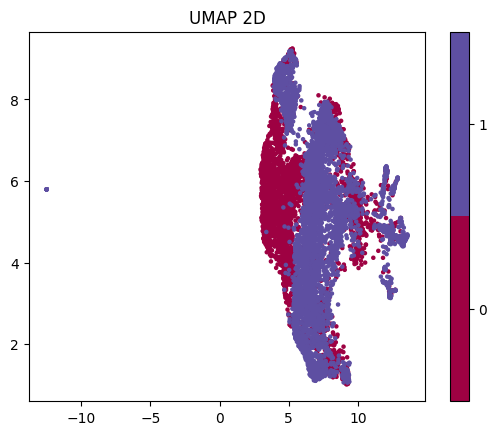

In [19]:
visualize_umap_2d(X_fft, y_simple, n_neighbors=np.sqrt(X_fft.shape[0]), min_dist=0.1, metric='euclidean')

/home/renan/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/renan/.local/lib/python3.10/site-packages/umap/umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/renan/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


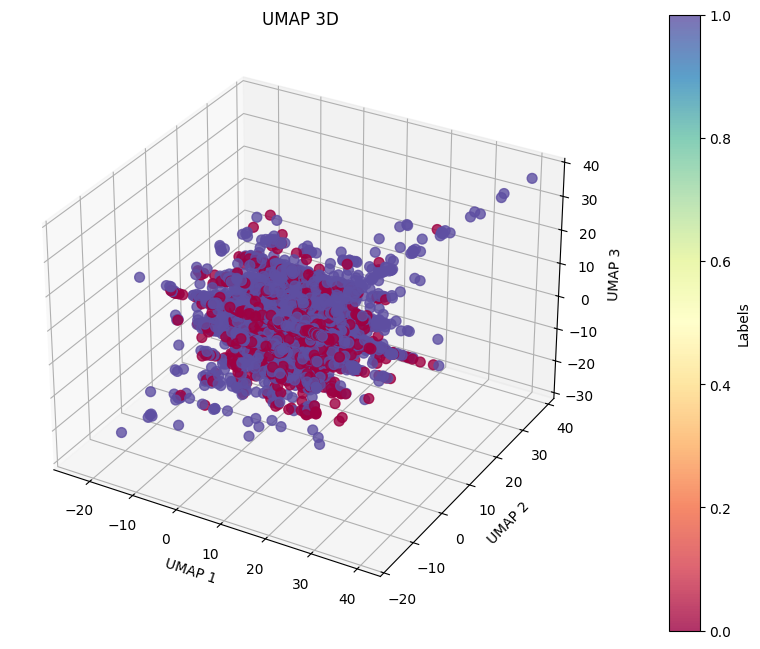

In [20]:
visualize_umap_3d(X_fft, y_simple, n_neighbors=np.sqrt(X_fft.shape[0]), min_dist=0.01, metric='euclidean', spread=0.2, title='UMAP 3D')

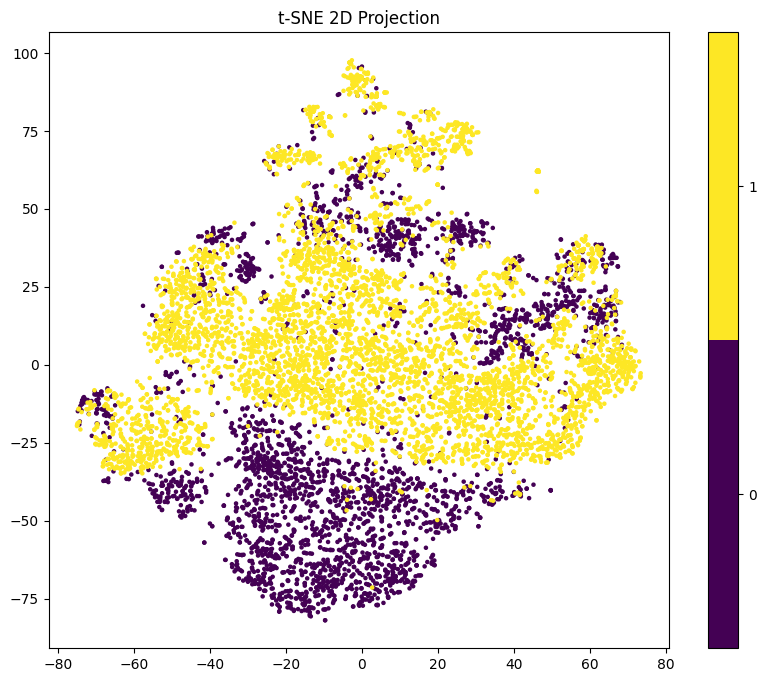

In [21]:
visualize_tsne_2d(X_fft, y_simple)

In [22]:
print(fit_kNN(X_simple, y_simple))

{'n_neighbors': 1}
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       683
           1       0.91      0.96      0.93      1065

    accuracy                           0.92      1748
   macro avg       0.92      0.91      0.91      1748
weighted avg       0.92      0.92      0.92      1748



In [23]:
print(fit_kNN(X_fft, y_simple))

{'n_neighbors': 10}
              precision    recall  f1-score   support

           0       0.96      0.70      0.81       683
           1       0.84      0.98      0.90      1065

    accuracy                           0.87      1748
   macro avg       0.90      0.84      0.86      1748
weighted avg       0.89      0.87      0.87      1748



### Trying fewer classes and dropping x_pos, y_pos

In [197]:
X_simple, y_simple = create_sliding_windows(df_list_simple, y_simple_numeric, window_size=20, step_size=10, drop_columns=['time', 'id', 'x_pos', 'y_pos'])
X_simple = StandardScaler().fit_transform(X_simple)

/home/renan/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


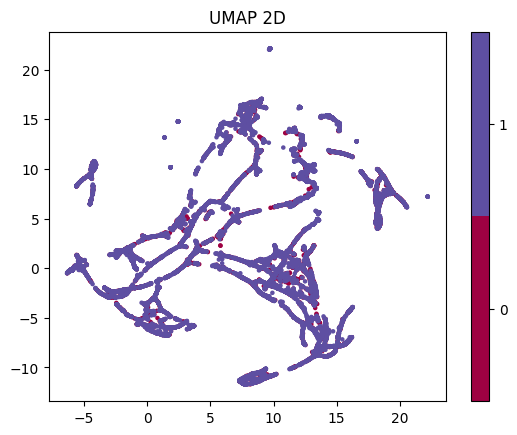

In [231]:
visualize_umap_2d(X_simple, y_simple, n_neighbors=50, min_dist=0.01, metric='euclidean')

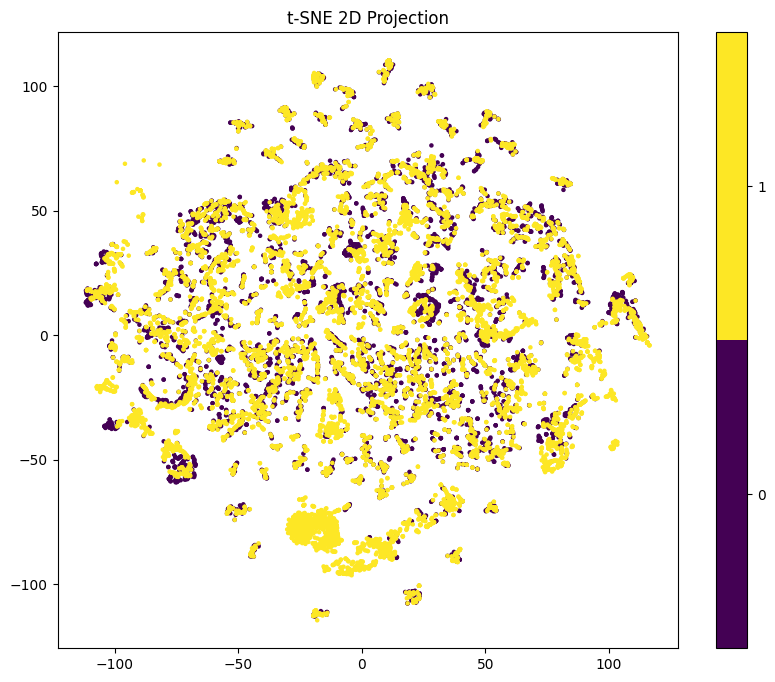

In [208]:
visualize_tsne_2d(X_simple, y_simple, perplexity=30)

In [209]:
print(fit_kNN(X_simple, y_simple))

{'n_neighbors': 1}
              precision    recall  f1-score   support

           0       0.77      0.65      0.71      1278
           1       0.81      0.88      0.85      2172

    accuracy                           0.80      3450
   macro avg       0.79      0.77      0.78      3450
weighted avg       0.80      0.80      0.79      3450



## AutoEncoder

In [39]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [14]:
class LSTMAutoEncoder(Model):
    def __init__(self, latent_space, input_shape):
        super(LSTMAutoEncoder, self).__init__()
        self.latent_space = latent_space
        self.input_shape = input_shape

        self.encoder = tf.keras.Sequential([
            layers.LSTM(128, activation='relu', return_sequences=True), # No need to specify input shape, since keras does that at runtime
            layers.LSTM(64, activation='relu', return_sequences=False),
            layers.Dense(latent_space, activation='relu')
        ])

        self.decoder = tf.keras.Sequential([
            layers.RepeatVector(input_shape[0]), # This layer repeats the input n times, where n is the number of time steps, so that the model will have the same representation for every timestep
            layers.LSTM(64, activation='relu', return_sequences=True),
            layers.LSTM(128, activation='relu', return_sequences=True),
            layers.TimeDistributed(layers.Dense(input_shape[1])) # This layer is used to apply a Dense layer to each time step, which is given by input_shape[1]. 
                                                                 # This will make the repeted vectors have the same number of features as the input
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [53]:
X_sliding_autoencoder = X_sliding.reshape(X_sliding.shape[0], window_size, X_sliding.shape[1]//window_size)
X_sliding_autoencoder.shape

(9075, 20, 5)

In [ ]:
X_autoencoder

In [54]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sliding_autoencoder.reshape(-1, X_sliding_autoencoder.shape[-1])) # Reshaping to (num_samples * timesteps, num_features) for scaling, garanteeing that each feature is scaled independently
X_scaled = X_scaled.reshape(X_sliding_autoencoder.shape) # Reshaping back to the original shape

In [55]:
X_train_autoencoder, X_test_autoencoder = train_test_split(X_scaled, test_size=0.2, random_state=42)

In [56]:
input_shape = (X_sliding_autoencoder.shape[1], X_sliding_autoencoder.shape[2]) # (window_size, num_features)
latent_space = 128

In [57]:
autoencoder = LSTMAutoEncoder(latent_space, input_shape)
autoencoder.compile(optimizer='adam', loss='mse')

In [59]:
autoencoder.fit(X_train_autoencoder, X_train_autoencoder, validation_data=(X_test_autoencoder, X_test_autoencoder), epochs=10, batch_size=128)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 6.5685 - val_loss: 2.6542e-05
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - loss: 2.7496 - val_loss: 2.4599e-05
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - loss: 3.4331 - val_loss: 2.0684e-05
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 1.5877 - val_loss: 1.7641e-05
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - loss: 1.0487 - val_loss: 1.5751e-05
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 2.3786 - val_loss: 1.4889e-05
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - loss: 0.5347 - val_loss: 1.4028e-05
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 3.3468 - val_loss: 2.1742e-05
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 276.3462 - val_loss: 2.8521e-05
Epoch 10/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - loss: 214.6253 - val_loss: 3.6642e-05


In [69]:
encoded_data = autoencoder.encoder(X_scaled).numpy()

/home/renan/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


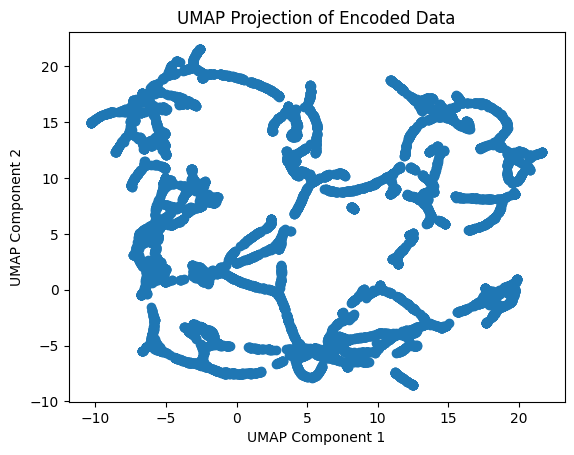

In [70]:
# Assuming encoded_X is your encoded data from the autoencoder
# Apply UMAP to reduce to 2 dimensions (for visualization)
umap_model = umap.UMAP(n_components=2)  # Set n_components to 2 for 2D visualization
encoded_2d = umap_model.fit_transform(encoded_data)

# Plot the 2D UMAP output
plt.scatter(encoded_2d[:, 0], encoded_2d[:, 1])
plt.title("UMAP Projection of Encoded Data")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

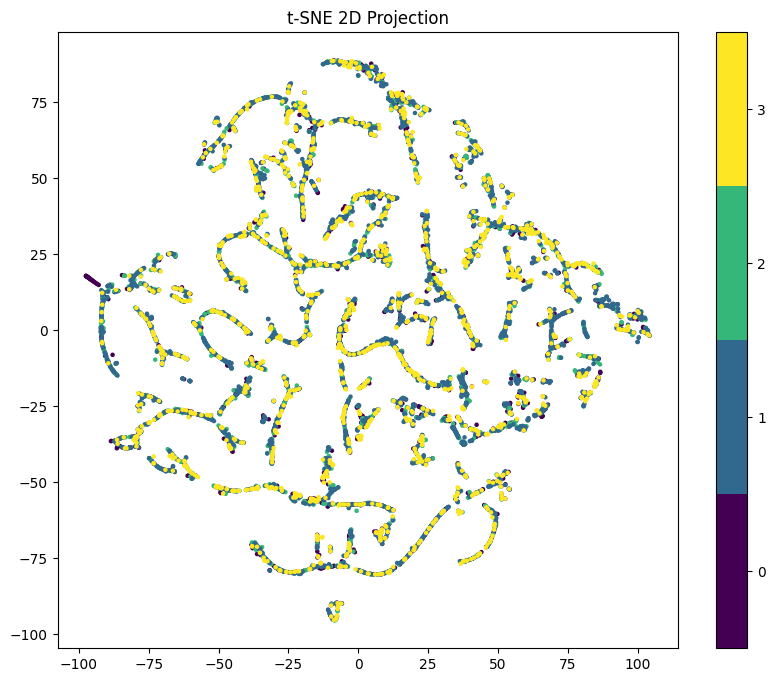

In [72]:
visualize_tsne_2d(encoded_data, y_sliding, perplexity=30)